In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
from scipy.stats import binned_statistic
from scipy.stats import theilslopes
from importlib import reload
from scipy.special import erf

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

sys.path.append('../')
import ana_fun as ana

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (11, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

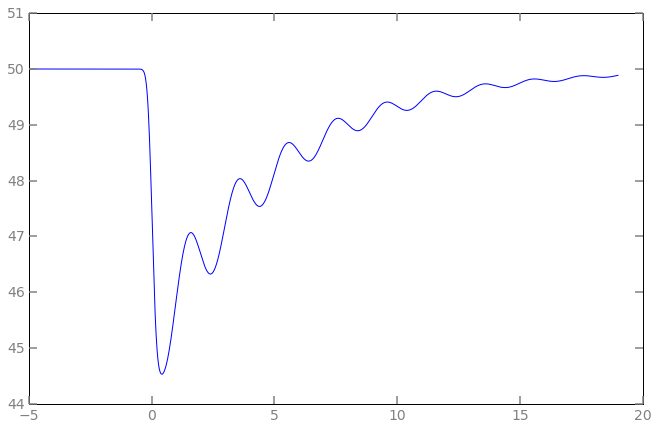

In [2]:
def y(t,a,w,phi,tau):
    return 50+0.5*(erf(t/0.2) + 1)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))

t = np.arange(-5,19,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))
plt.ylim(44,51)
plt.show()

In [3]:
t_sim     =  np.random.rand(50*len(t))*24-5
e_sim     =  np.random.normal(916,3,len(t_sim))
y_sim     =  y(t_sim,1,np.pi,3.1,5)
IFEE_sim  =  np.random.rand(len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(e_sim-913)**2/4**2)+np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim * (e_sim-895) +np.random.normal(0,1,len(t_sim))**2
I0_sim.shape

(120000,)

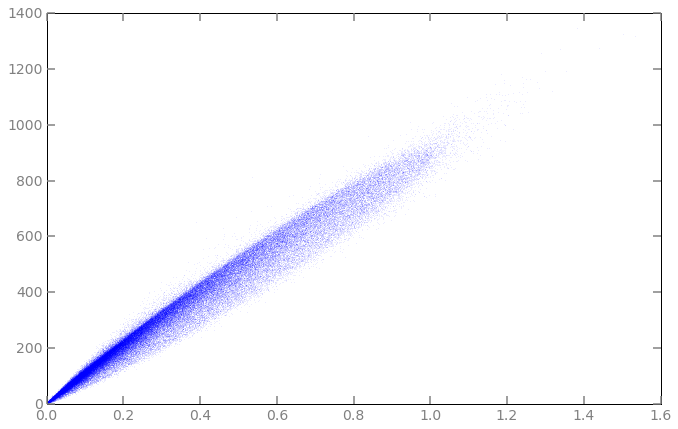

In [4]:
plt.plot(I0_sim, I_sim, '.', markersize=0.1)
plt.show()

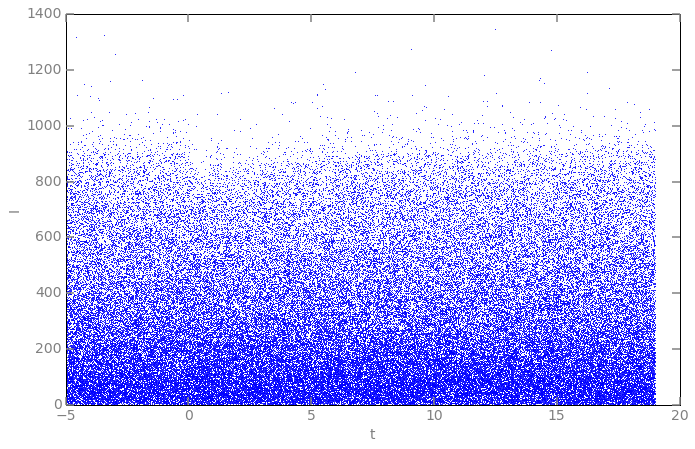

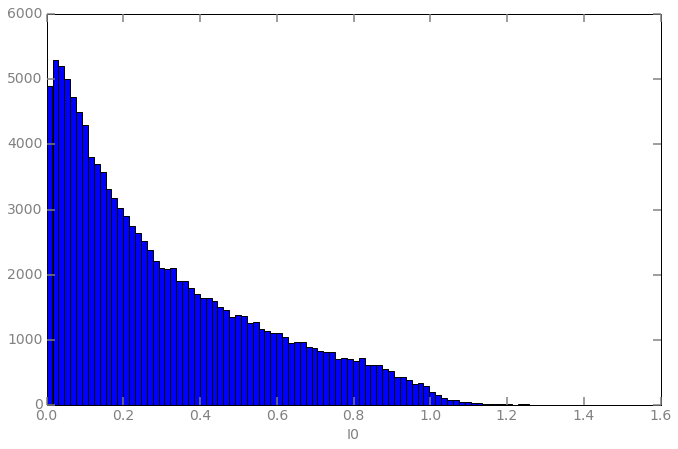

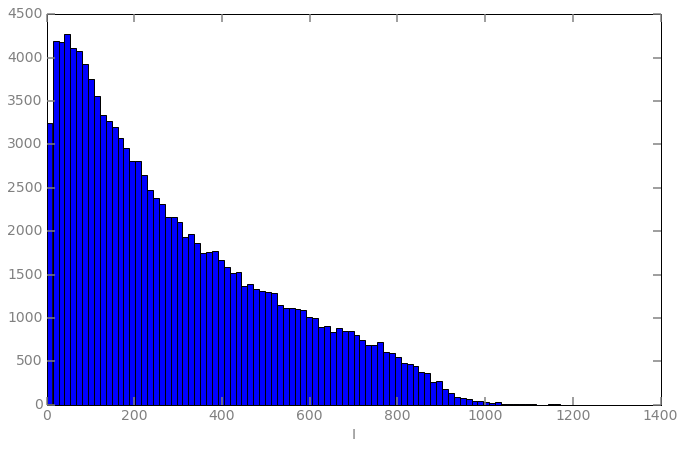

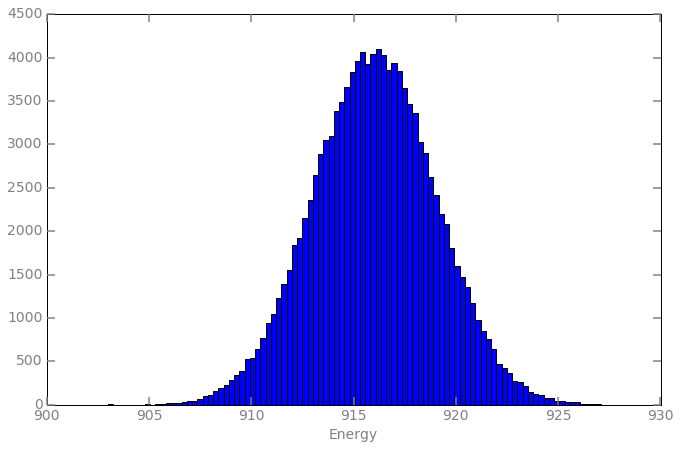

In [5]:
plt.plot(t_sim, I_sim, '.', markersize=1)
plt.xlabel('t')
plt.ylabel('I')

plt.figure()
plt.hist(I0_sim, bins=100)
plt.xlabel('I0')

plt.figure()
plt.hist(I_sim, bins=100)
plt.xlabel('I')

plt.figure()
plt.hist(e_sim, bins=100)
plt.xlabel('Energy')
plt.show()

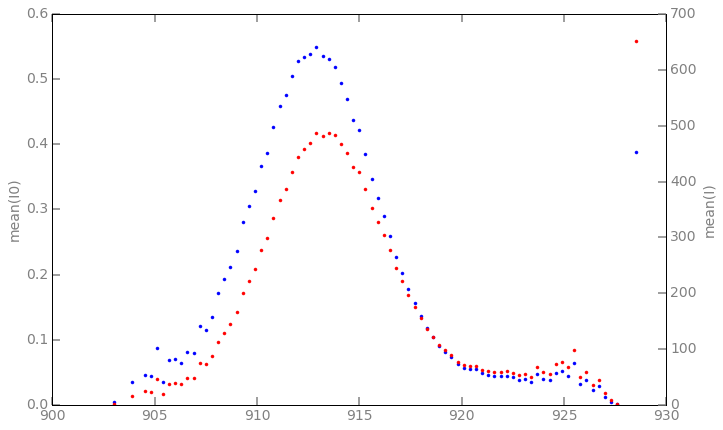

In [6]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[:-1],my_binned_stat.statistic,'.')
plt.ylabel('mean(I0)')
plt.twinx()
my_binned_stat = binned_statistic(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[:-1],my_binned_stat.statistic,'.',color='r')
plt.ylabel('mean(I)')
plt.show()

In [7]:
beta, Xbeta = ana.linearize_energy(I_sim,I0_sim,e_sim)
energy_I0_product = (e_sim-np.mean(e_sim))*(I0_sim-np.mean(I0_sim))
X = np.array([np.ones(len(I0_sim)), I0_sim, e_sim, energy_I0_product]).transpose()
Icorr = I_sim - np.matmul(X[:,2:]-np.mean(X,axis=0)[2:], beta[2:])

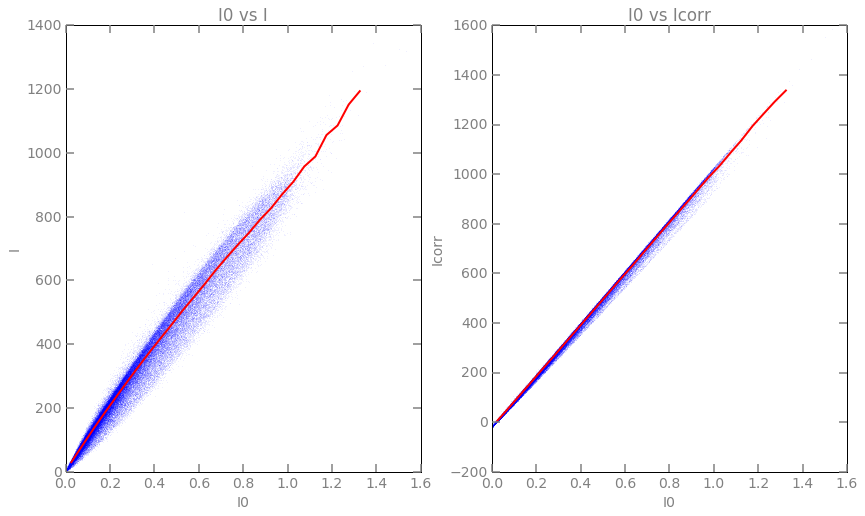

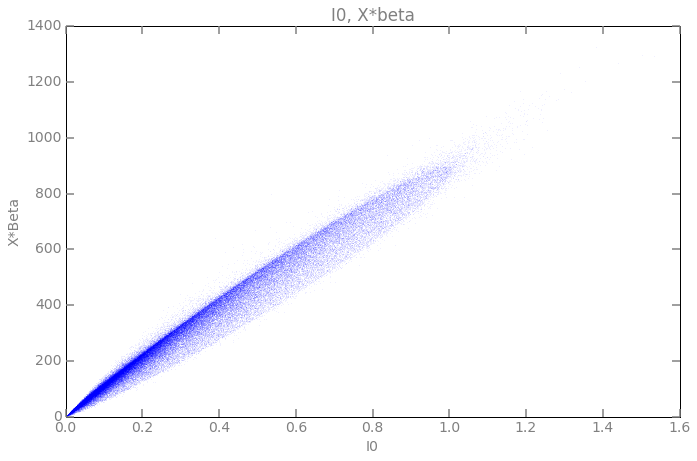

In [8]:
""" Visualization """
plt.figure('I0 correlation: comparison', figsize=(14,8))
plt.subplot(1,2,2)
plt.plot(I0_sim, Icorr, '.', markersize=0.08)
plt.title('I0 vs Icorr')
plt.xlabel('I0')
plt.ylabel('Icorr')

bins = np.arange(0,1.4,0.05)
med = binned_statistic(I0_sim, Icorr, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2, color='red')
#plt.xlim([-0.02,1.3])
#plt.ylim([-0.01,0.8])

plt.subplot(1,2,1)
plt.plot(I0_sim, I_sim, '.', markersize=0.08)
plt.title('I0 vs I')
plt.xlabel('I0')
plt.ylabel('I')

med = binned_statistic(I0_sim, I_sim, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2, color='red')
#plt.xlim([-0.02,1.3])
#plt.ylim([-0.01,0.8])
plt.show()



plt.figure()
plt.title('I0, X*beta')
plt.plot(I0_sim,Xbeta,'.',markersize=0.08)
plt.xlabel('I0')
plt.ylabel('X*Beta')
#plt.xlim([-0.01,1.3])
#plt.ylim([-0.01,0.8])
plt.show()

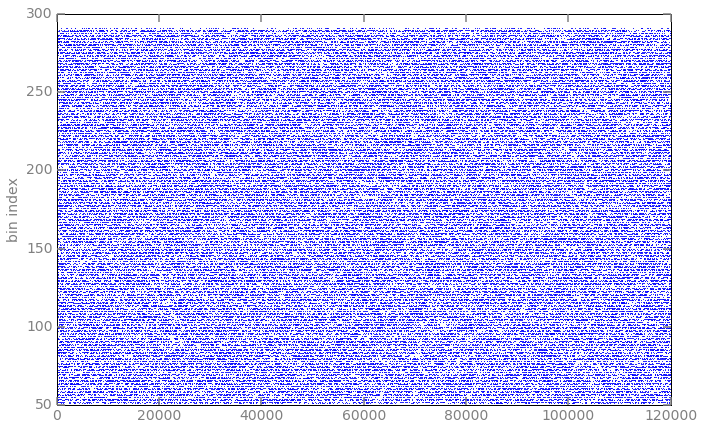

In [9]:
tbin_centers = np.arange(-10,20,0.1)
#tbin_centers = np.arange(-20,5,0.1)

""" Compute bin edges """
binDiff = np.diff(tbin_centers)
binDiff = np.append(binDiff, binDiff[-1])
binEdges = tbin_centers+binDiff/2
binEdges = np.append(binEdges[0]-binDiff[0], binEdges)

binIds = np.digitize(t_sim, binEdges)

plt.plot(binIds, '.', markersize=1)
plt.ylabel('bin index')
plt.show()

In [10]:
def get_slope_bin(y,x,binIds,binNb):
    inBin = binIds == binNb
    xbin = x[inBin]
    ybin = y[inBin]
    dataPointNb = np.sum(inBin)
    if dataPointNb>1:
        theilslopes_res = theilslopes(ybin, xbin, alpha=0.95)
        theilslopes_err = (theilslopes_res[3]-theilslopes_res[2])/2
        return np.array([theilslopes_res[0], theilslopes_err, theilslopes_res[1], dataPointNb])
    else:
        return np.array([np.nan, np.nan, np.nan, dataPointNb])
    
time = np.asarray([tbin_centers[binNb] for binNb in np.unique(binIds)])
sig = np.asarray([get_slope_bin(I_sim,I0_sim,binIds,binNb) for binNb in np.unique(binIds)])

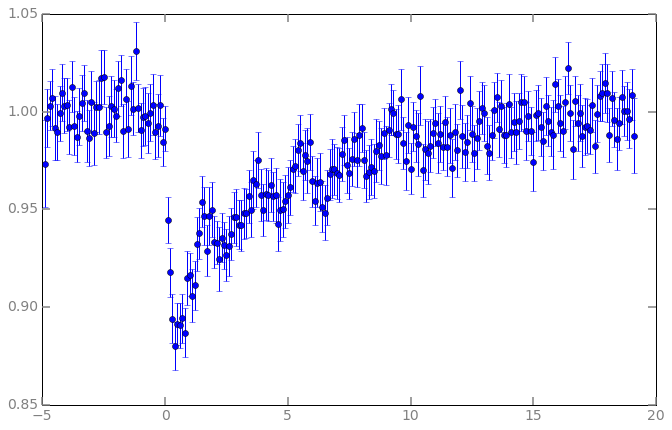

In [11]:
beforet0 = sig[time<0,0]
beforet0 = beforet0[~np.isnan(beforet0)][4:]

plt.figure('pump probe')
plt.errorbar(time, sig[:,0]/np.mean(beforet0), sig[:,1]/np.mean(beforet0), marker='o', linestyle='None')
plt.show()